In [1]:
import numpy as np
import pandas as pd
from itertools import product
import os
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

from pyproj import CRS, Transformer
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

### Locate data

In [2]:
# This seems to be the global grid of rasters, same for every day!
start_x = 48262
end_x = 362968
start_y = 426468
end_y = 934214
num_x = int( ( end_x - start_x ) / 127 )
num_y = int( ( end_y - start_y ) / 127 )

# this raster encoding is universal then
raster_x = np.arange(start_x, end_x+127, 127, dtype=np.int32)
raster_y = np.arange(start_y, end_y+127, 127, dtype=np.int32)

# get coordinate vector
raster_coords = np.array( list(product( raster_x, raster_y )) )

In [3]:
source = '/media/Data_storage/Mobilcell/DayPolygonData/'

In [4]:
files_pol_enc = np.array( sorted( [ i for i in os.listdir( source ) if 'encoded' in i] ) )
files_pol_enc[:3], files_pol_enc.shape

(array(['polygon_encoded_20181201.npy', 'polygon_encoded_20181202.npy',
        'polygon_encoded_20181203.npy'], dtype='<U28'), (365,))

In [5]:
towers_unique = np.load( source+'unique-tower-id_all.npy' )
towers_unique[:3]

array([[71892,   218,   147,     0,     0,     0,     0],
       [72307,   218,   147,     0,     0,     0,     0],
       [72922,   218,   147,     0,     0,     0,     0]], dtype=int32)

In [6]:
pol_enc = np.load( source + files_pol_enc[0] )
pol_enc[:3]

array([[10071347,  5311222],
       [10071347,  5311223],
       [10071347,  5315221]])

cell id min, cell id max, encoding min, encoding max

In [7]:
pol_enc[:,0].min(), pol_enc[:,0].max(), pol_enc[:,1].min(), pol_enc[:,1].max()

(71892, 553841790, 1029, 9912671)

In [8]:
# sort with the raster encoding
sort_idx = np.argsort( pol_enc[:,1] )
pol_enc_raster = pol_enc[ sort_idx ]

pol_enc_diff_idx = np.where( np.diff( pol_enc_raster[:,1] ) )[0]+1
# insert first element (zero) ## otherwise left out!
pol_enc_idx = np.insert(pol_enc_diff_idx, 0, 0, axis=0)
# insert last element (size of array) ## otherwise left out!
pol_enc_idx = np.append( pol_enc_idx, pol_enc.shape[0] )

# generate index array
all_idx_raster = np.vstack( ( pol_enc_idx[:-1], pol_enc_idx[1:] ) ).T

In [9]:
rasters_all = []
towers_all = []
for i in tqdm( all_idx_raster ):
    rasters_all.append( pol_enc_raster[:,1][ i[0] ] )
    towers_all.append( pol_enc_raster[:,0][ i[0]:i[1] ] )

100%|██████████| 5737315/5737315 [00:08<00:00, 668057.58it/s]


In [10]:
raster_to_tower = dict( zip( rasters_all, towers_all ) )

In [11]:
len(raster_to_tower)

5737315

#### Current raster belongs to these towers

In [12]:
raster_to_tower[1029], raster_to_tower[1156]

(array([126727438]), array([ 20344643,  11141488, 109301607]))

#### Go the other way

In [13]:
sort_idx = np.argsort( pol_enc[:,0] )
pol_enc_tower = pol_enc[ sort_idx ]

pol_enc_diff_idx = np.where( np.diff( pol_enc_tower[:,0] ) )[0]+1
# insert first element (zero) ## otherwise left out!
pol_enc_idx = np.insert(pol_enc_diff_idx, 0, 0, axis=0)
# insert last element (size of array) ## otherwise left out!
pol_enc_idx = np.append( pol_enc_idx, pol_enc.shape[0] )

all_idx_tower = np.vstack( ( pol_enc_idx[:-1], pol_enc_idx[1:] ) ).T

In [14]:
pol_enc_tower[:2], pol_enc_raster[:2]

(array([[  71892, 6379446],
        [  71892, 6395447]]), array([[126727438,      1029],
        [126727438,      1030]]))

In [15]:
pol_enc_tower[:5]

array([[  71892, 6379446],
       [  71892, 6395447],
       [  71892, 6395446],
       [  71892, 6395445],
       [  71892, 6395444]])

In [16]:
tower_id_all = []
overlaps_all = []
for j in tqdm( all_idx_tower ):
    tower_id_all.append( pol_enc_tower[:,0][ j[0] ] )
    overlaps_all.append( np.unique( 
        np.concatenate( [ raster_to_tower[k] 
                          for k in pol_enc_tower[:,1][ j[0]:j[1] ] ] ) ) )
tower_id_all = np.array( tower_id_all )
overlaps_all = np.array( overlaps_all )

100%|██████████| 42785/42785 [00:12<00:00, 3296.84it/s]


In [17]:
tower_id_all[0], overlaps_all[0], tower_id_all[1], overlaps_all[1]

(71892,
 array([    71892,     73325,   6825557,   6845331,   6845706,   6860697,
          8321740,  19057549,  26918276,  26918325,  30531989,  61228250,
         61228299,  61228351,  61228404,  61228460,  61228529,  64544418,
         67567941,  67567956,  69448296,  69450334,  78629973,  78630032,
         78641043,  78642084,  78642123, 116372605, 152657683, 152657802,
        176829342, 196621189, 196621467, 196621544, 252707029, 252707087,
        252707298, 317324304, 368276364, 378944041, 378944862]),
 72307,
 array([    72307,     73325,   6698027,   6845331,   7250325,   8321740,
         10071903,  19057549,  26649548,  26918276,  30488204,  30531989,
         61228250,  61228299,  61228404,  61228460,  64544418,  64547158,
         67482998,  67567941,  67567956,  69448296,  69450334,  78629973,
         78630032,  78641043,  78642084,  85548085,  85548144, 116372605,
        176829342, 198282653, 198284065, 198284117, 252695290, 252695493,
        252695822, 317324304, 3

#### Here load universal grid

In [18]:
# all unique ids of polygons for the whole year
tower_id_all_global = np.load( source+'unique-tower-id_all.npy' )[:,0] # 0th column contains the ids
tower_to_int_all = dict( zip( tower_id_all_global, np.arange( tower_id_all_global.shape[0] ) ) )

In [19]:
tower_to_int_all[71892], len( tower_to_int_all )

(0, 43384)

#### Replace 
    tower_to_int
    
to

    tower_to_int_all

In [20]:
tower_id_all

array([    71892,     72307,     72922, ..., 553841622, 553841698,
       553841790])

In [21]:
len( [ tower_to_int_all[ s ] for s in tower_id_all ] )

42785

In [22]:
overlaps_all

array([array([    71892,     73325,   6825557,   6845331,   6845706,   6860697,
         8321740,  19057549,  26918276,  26918325,  30531989,  61228250,
        61228299,  61228351,  61228404,  61228460,  61228529,  64544418,
        67567941,  67567956,  69448296,  69450334,  78629973,  78630032,
        78641043,  78642084,  78642123, 116372605, 152657683, 152657802,
       176829342, 196621189, 196621467, 196621544, 252707029, 252707087,
       252707298, 317324304, 368276364, 378944041, 378944862]),
       array([    72307,     73325,   6698027,   6845331,   7250325,   8321740,
        10071903,  19057549,  26649548,  26918276,  30488204,  30531989,
        61228250,  61228299,  61228404,  61228460,  64544418,  64547158,
        67482998,  67567941,  67567956,  69448296,  69450334,  78629973,
        78630032,  78641043,  78642084,  85548085,  85548144, 116372605,
       176829342, 198282653, 198284065, 198284117, 252695290, 252695493,
       252695822, 317324304, 368276364, 378944

In [23]:
overlap_matrix = np.zeros( (len(tower_to_int_all), len(tower_to_int_all)), dtype=np.int16 )
for n in range( tower_id_all.shape[0] ):
    line = tower_to_int_all[ tower_id_all[n] ]
    idx_to_add_at = [ tower_to_int_all[q] for q in overlaps_all[n] ]
    np.add.at( overlap_matrix[line], idx_to_add_at, 1 )

In [24]:
overlap_matrix, overlap_matrix.shape

(array([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int16), (43384, 43384))

In [25]:
(np.array([ overlap_matrix[q,q] for q in range( overlap_matrix.shape[0] ) ]) > 0).sum()

42785

### Consider area of overlaps too!

In [26]:
tower_id_all = []
overlaps_counts_all = []
overlaps_all = []
for j in tqdm( all_idx_tower ):
    tower_id_all.append( pol_enc_tower[:,0][ j[0] ] )
    ov_uniq, ov_counts = np.unique( 
                                    np.concatenate( [ raster_to_tower[k] 
                                    for k in pol_enc_tower[:,1][ j[0]:j[1] ] ] ),
                                   return_counts=True )
    overlaps_all.append( ov_uniq ) 
    overlaps_counts_all.append( ov_counts )
tower_id_all = np.array( tower_id_all )
overlaps_all = np.array( overlaps_all )

100%|██████████| 42785/42785 [00:13<00:00, 3132.74it/s]


In [27]:
tower_id_all[0], overlaps_all[0], overlaps_counts_all[0]

(71892,
 array([    71892,     73325,   6825557,   6845331,   6845706,   6860697,
          8321740,  19057549,  26918276,  26918325,  30531989,  61228250,
         61228299,  61228351,  61228404,  61228460,  61228529,  64544418,
         67567941,  67567956,  69448296,  69450334,  78629973,  78630032,
         78641043,  78642084,  78642123, 116372605, 152657683, 152657802,
        176829342, 196621189, 196621467, 196621544, 252707029, 252707087,
        252707298, 317324304, 368276364, 378944041, 378944862]),
 array([3956,  701,  152,    3,    1,    2,  294,   20,  142,    5,  294,
        3465,   13,   13, 3465,   13,   13,   20,  550,    4,    1,   32,
           1,    1,   20,  142,    5,  830,    3,    3,  699,    1,    1,
           1,    1,    1,    1,  406, 2944,   44,    2]))

In [36]:
(np.array([ i[0] for i in overlaps_counts_all ]) > 0 ).sum()

42785

In [44]:
overlap_matrix = np.zeros( (len(tower_to_int_all), len(tower_to_int_all)), 
                            dtype=np.uint16 )
for n in range( tower_id_all.shape[0] ):
    line = tower_to_int_all[ tower_id_all[n] ]
    idx_to_add_at = [ tower_to_int_all[ q ] for q in overlaps_all[n] ]
    np.add.at(overlap_matrix[line], idx_to_add_at, overlaps_counts_all[n] )

In [42]:
(np.array([ i[0] for i in overlaps_counts_all ]) > 0 ).sum()

42785

In [47]:
norm_factor = np.ones( overlap_matrix.shape[0], dtype=np.uint16 )
nonzero = overlap_matrix[ np.diag_indices(overlap_matrix.shape[0]) ] > 0
norm_factor[nonzero] = overlap_matrix[ np.diag_indices(overlap_matrix.shape[0]) ][nonzero]
overlap_matrix_normed = (overlap_matrix / norm_factor).astype(np.float16)

In [48]:
'overlap-matrix_normed_'+files_pol_enc[0].split('_')[-1][:8]

'overlap-matrix_normed_20181201'

In [34]:
type( overlap_matrix_normed[0,0] )

numpy.float16

In [49]:
norm_factor

array([3956, 2750, 1938, ...,  210,  618,  548], dtype=uint16)

In [50]:
overlap_matrix.max()

43852

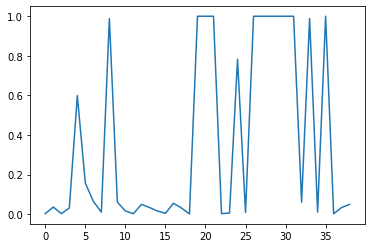

In [35]:
plt.plot(overlap_matrix_normed[40000,:][ (overlap_matrix_normed[40000,:] > 0) ])

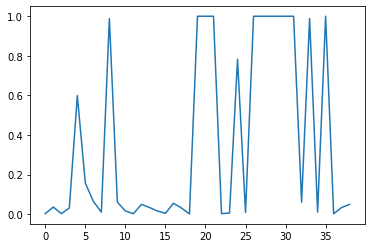

In [51]:
plt.plot(overlap_matrix_normed[40000,:][ (overlap_matrix_normed[40000,:] > 0) ])

In [31]:
(overlap_matrix_normed > 0.5).sum(), (overlap_matrix_normed > 0.7).sum(), (overlap_matrix_normed > 0.99).sum()

(324224, 293214, 246908)

In [32]:
overlap_fraction = 0.99
adj_mat = (overlap_matrix_normed > overlap_fraction )*1

In [33]:
adj_mat.shape

(43384, 43384)

In [34]:
adj_mat[0,:]

array([1, 0, 0, ..., 0, 0, 0])

In [37]:
(adj_mat[1,:] > 0).sum()

10

In [38]:
[ (adj_mat[j,:] > 0).sum() for j in range(adj_mat.shape[0]) ]

[9,
 10,
 1,
 17,
 5,
 1,
 2,
 2,
 2,
 2,
 4,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 1,
 3,
 2,
 4,
 98,
 98,
 98,
 6,
 6,
 2,
 4,
 2,
 2,
 3,
 9,
 2,
 2,
 2,
 2,
 4,
 3,
 3,
 2,
 4,
 5,
 1,
 2,
 2,
 4,
 4,
 3,
 2,
 1,
 1,
 1,
 6,
 14,
 3,
 2,
 7,
 7,
 2,
 1,
 1,
 4,
 1,
 2,
 14,
 4,
 2,
 14,
 4,
 2,
 1,
 23,
 8,
 7,
 23,
 8,
 7,
 2,
 1,
 1,
 7,
 25,
 20,
 8,
 25,
 20,
 12,
 8,
 4,
 12,
 8,
 4,
 3,
 3,
 2,
 3,
 3,
 2,
 1,
 1,
 9,
 1,
 11,
 6,
 1,
 6,
 3,
 1,
 11,
 3,
 1,
 1,
 1,
 8,
 8,
 8,
 8,
 1,
 1,
 1,
 12,
 1,
 2,
 4,
 5,
 1,
 5,
 1,
 4,
 7,
 1,
 4,
 1,
 11,
 1,
 3,
 37,
 2,
 3,
 1,
 1,
 3,
 12,
 1,
 8,
 1,
 8,
 11,
 5,
 7,
 1,
 13,
 4,
 16,
 21,
 4,
 6,
 1,
 1,
 1,
 4,
 6,
 6,
 6,
 3,
 2,
 5,
 13,
 1,
 6,
 6,
 3,
 5,
 6,
 4,
 1,
 1,
 2,
 3,
 1,
 4,
 1,
 1,
 5,
 3,
 1,
 5,
 9,
 2,
 4,
 9,
 1,
 3,
 3,
 2,
 1,
 1,
 3,
 4,
 7,
 1,
 1,
 1,
 4,
 2,
 1,
 1,
 4,
 4,
 1,
 4,
 4,
 5,
 3,
 1,
 4,
 4,
 3,
 1,
 17,
 1,
 5,
 1,
 2,
 4,
 1,
 1,
 5,
 1,
 5,
 1,
 1,
 5,
 2,
 5,
 5,
 5,
 5,
 5,
 1,
 2,


In [ ]:
adj_mat == (adj_mat + adj_mat.T) / 2

In [35]:
G = nx.from_numpy_matrix(adj_mat)
len( G.nodes() ), len( G.edges() )

(43384, 191278)

In [36]:
nx.connected_components(G)

<generator object connected_components at 0x7fae7fef5410>

In [37]:
[ c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]

{14,
 15,
 32786,
 32787,
 32788,
 32789,
 32790,
 32791,
 32792,
 32793,
 26,
 32794,
 28,
 32795,
 32796,
 32797,
 23,
 24,
 25,
 34,
 37,
 38,
 39,
 43,
 45,
 46,
 47,
 48,
 39088,
 55,
 56,
 57,
 58,
 39089,
 59,
 60,
 39090,
 32834,
 32840,
 39093,
 102,
 104,
 105,
 107,
 108,
 109,
 110,
 115,
 116,
 117,
 118,
 122,
 39102,
 125,
 127,
 32906,
 32907,
 32908,
 140,
 138,
 139,
 144,
 146,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 158,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 39111,
 39112,
 39113,
 32948,
 32949,
 32953,
 32957,
 32958,
 32961,
 32964,
 39117,
 39118,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 33008,
 33009,
 33010,
 33011,
 33012,
 33013,
 33014,
 33015,
 33016,
 33017,
 33018,
 33019,
 33020,
 33021,
 33022,
 33023,
 33024,
 33025,
 33026,
 33027,
 260,
 254,
 262,
 263,
 264,
 33031,
 257,
 261,
 33028,
 33029,
 33030,
 267,
 272,
 274,
 277,
 278,
 279,
 280,
 281,
 282,
 33048,
 33053,
 33054,
 308,
 309,
 310,
 33079,
 311,
 39139,
 33078,
